<a href="https://colab.research.google.com/github/Naveyah0607/Assignment2/blob/main/DQN_Assgnmt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium==0.27.1 -q
!pip install gymnasium[box2d] -q
!pip install moviepy -q
!pip install -U kora -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Assgnmt2_DQN
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Assgnmt2_DQN
CartPole	    CartPole_v1_t1.pkl	CartPole_v1_t3.pkl
CartPole_v1_t0.pkl  CartPole_v1_t2.pkl	CartPole_v1_t4.pkl


In [ ]:
import random
import numpy as np
import torch

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)


def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def apply_discount(raw_reward, gamma=0.99):
    discounted_rtg_reward = []
    discounted_sum = 0
    for reward in reversed(raw_reward):
        discounted_sum = discounted_sum * gamma + reward
        discounted_rtg_reward.append(discounted_sum)
    discounted_rtg_reward.reverse()
    return (torch.tensor(discounted_rtg_reward, dtype=torch.float32, device=get_device())
            - torch.tensor(discounted_rtg_reward, dtype=torch.float32, device=get_device()).mean()
            / (torch.tensor(discounted_rtg_reward, dtype=torch.float32, device=get_device()).std() + np.finfo(np.float32).eps))

In [ ]:
from collections import deque
import random
import copy
import pickle
import random
import gymnasium as gym
import torch
from collections import deque, namedtuple
from gymnasium.utils.save_video import save_video
from torch import nn
from torch.optim import Adam
from torch.distributions import Categorical

class DQNTrainer:
    def __init__(self, params):
        self.params = params
        self.env = gym.make(self.params['env_name'])
        self.q_net = QNet(input_size=self.env.observation_space.shape[0], output_size=self.env.action_space.n, hidden_dim=self.params['hidden_dim']).to(get_device())
        self.target_net = QNet(input_size=self.env.observation_space.shape[0], output_size=self.env.action_space.n, hidden_dim=self.params['hidden_dim']).to(get_device())
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.epsilon = self.params['init_epsilon']
        self.optimizer = Adam(params=self.q_net.parameters(), lr=self.params['lr'])
        self.replay_memory = ReplayMemory(capacity=self.params['rm_cap'])

    def run_training_loop(self):
        list_ep_reward = list()
        obs, _ = self.env.reset(seed=self.params['rng_seed'])
        for idx_episode in range(self.params['n_episode']):
            ep_len = 0
            while True:
                ep_len += 1
                action = self.get_action(obs)
                next_obs, reward, terminated, truncated, info = self.env.step(action)
                if terminated or truncated:
                    self.epsilon = max(self.epsilon*self.params['epsilon_decay'], self.params['min_epsilon'])
                    next_obs = None
                    self.replay_memory.push(obs, action, reward, next_obs, not (terminated or truncated))
                    list_ep_reward.append(ep_len)
                    print(f'End of episode {idx_episode} with epsilon = {self.epsilon: 0.2f} and reward = {ep_len}, memory = {len(self.replay_memory.buffer)}')
                    obs, _ = self.env.reset()
                    break
                self.replay_memory.push(obs, action, reward, next_obs, not (terminated or truncated))
                obs = copy.deepcopy(next_obs)
                self.update_q_net()
                self.update_target_net()
        # Save avg-rewards as pickle files
        pkl_file_name = self.params['exp_name'] + '.pkl'
        with open(pkl_file_name, 'wb') as f:
            pickle.dump(list_ep_reward, f)
        # Save a video of the trained agent playing
        self.generate_video()
        # Close environment
        self.env.close()

    def get_action(self, obs):
          obs = torch.from_numpy(obs).float()
          q_values = self.q_net(obs)
          if np.random.uniform(0,1) < self.epsilon:
              action = self.env.action_space.sample()
          else:
              action = q_values.argmax(dim=0).item()
          return  action


    def update_q_net(self):
        if len(self.replay_memory.buffer) < self.params['batch_size']:
            return
        state, action, reward, next_state, done = self.replay_memory.sample(self.params['batch_size'])
        predicted_state_value = self.q_net.forward(state).gather(1, action.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            target_value = reward + self.params['gamma'] * (1 - done) * self.target_net(next_state).max(1)[0]
        criterion = nn.SmoothL1Loss()
        q_loss = criterion(predicted_state_value, target_value.unsqueeze(1))
        self.optimizer.zero_grad()
        q_loss.backward()
        self.optimizer.step()


    def update_target_net(self):
        if len(self.replay_memory.buffer) < self.params['batch_size']:
            return
        q_net_state_dict = self.q_net.state_dict()
        target_net_state_dict = self.target_net.state_dict()
        for key in q_net_state_dict:
            target_net_state_dict[key] = self.params['tau']*q_net_state_dict[key] + (1 - self.params['tau'])*target_net_state_dict[key]
        self.target_net.load_state_dict(target_net_state_dict)

    def generate_video(self, max_frame=1000):
        self.env = gym.make(self.params['env_name'], render_mode='rgb_array_list')
        self.epsilon = 0.0
        obs, _ = self.env.reset()
        for _ in range(max_frame):
            action = self.get_action(obs)
            obs, reward, terminated, truncated, info = self.env.step(action)
            if terminated or truncated:
                break
        save_video(frames=self.env.render(), video_folder=self.params['env_name'][:-3], fps=self.env.metadata['render_fps'], step_starting_index=0, episode_index=0)




class ReplayMemory:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        transition = (state, action, reward, next_state, done)
        self.buffer.append(transition)

    def sample(self, n_samples):
        batch = random.sample(self.buffer, n_samples)
        batch = [e for e in batch if e is not None]
        states, actions, rewards, next_states, dones = zip(*batch)
        next_states = [
        np.zeros_like(state) if next_state is None else next_state
        for state, next_state in zip(states, next_states)
        ]
    
        batch = [elem for elem in batch if elem is not None]

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        return states, actions, rewards, next_states, dones






class QNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim):
        super(QNet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_size)
        )

    def forward(self, obs):
        return self.network(obs)

In [ ]:
params_list = [
    
 {
    'env_name': 'CartPole-v1',
    'rng_seed': 6369,
    'n_episode': 350,
    'rm_cap': 8192,
    'batch_size': 128,
    'hidden_dim': 128,
    'init_epsilon': 0.9,
    'min_epsilon': 0.5,
    'epsilon_decay': 0.99,
    'gamma': 0.99,
    'tau': 0.5,
    'lr': 3e-3,
    'exp_name': 'CartPole_v1_t0'
},
    
 {
    'env_name': 'CartPole-v1',
    'rng_seed': 6369,
    'n_episode': 350,
    'rm_cap': 8192,
    'batch_size': 128,
    'hidden_dim': 128,
    'init_epsilon': 0.9,
    'min_epsilon': 0.5,
    'epsilon_decay': 0.99,
    'gamma': 0.99,
    'tau': 0.05,
    'lr': 3e-3,
    'exp_name': 'CartPole_v1_t1'
},
     
 {
    'env_name': 'CartPole-v1',
    'rng_seed': 6369,
    'n_episode': 350,
    'rm_cap': 8192,
    'batch_size': 128,
    'hidden_dim': 128,
    'init_epsilon': 0.9,
    'min_epsilon': 0.5,
    'epsilon_decay': 0.99,
    'gamma': 0.99,
    'tau': 0.005,
    'lr': 3e-3,
    'exp_name': 'CartPole_v1_t2'
}
]

# Train agent with each set of parameters
for params in params_list:
    # Seed RNGs
    seed_everything(params['rng_seed'])
# Train agent
    trainer = DQNTrainer(params)
    trainer.run_training_loop()

End of episode 0 with epsilon =  0.89 and reward = 13, memory = 13
End of episode 1 with epsilon =  0.88 and reward = 13, memory = 26
End of episode 2 with epsilon =  0.87 and reward = 16, memory = 42
End of episode 3 with epsilon =  0.86 and reward = 11, memory = 53
End of episode 4 with epsilon =  0.86 and reward = 14, memory = 67
End of episode 5 with epsilon =  0.85 and reward = 15, memory = 82
End of episode 6 with epsilon =  0.84 and reward = 18, memory = 100
End of episode 7 with epsilon =  0.83 and reward = 16, memory = 116


<ipython-input-4-7547363b05c7>:121: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  states = torch.tensor(states, dtype=torch.float32)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


End of episode 8 with epsilon =  0.82 and reward = 43, memory = 159
End of episode 9 with epsilon =  0.81 and reward = 26, memory = 185
End of episode 10 with epsilon =  0.81 and reward = 11, memory = 196
End of episode 11 with epsilon =  0.80 and reward = 12, memory = 208
End of episode 12 with epsilon =  0.79 and reward = 18, memory = 226
End of episode 13 with epsilon =  0.78 and reward = 34, memory = 260
End of episode 14 with epsilon =  0.77 and reward = 31, memory = 291
End of episode 15 with epsilon =  0.77 and reward = 43, memory = 334
End of episode 16 with epsilon =  0.76 and reward = 15, memory = 349
End of episode 17 with epsilon =  0.75 and reward = 14, memory = 363
End of episode 18 with epsilon =  0.74 and reward = 10, memory = 373
End of episode 19 with epsilon =  0.74 and reward = 53, memory = 426
End of episode 20 with epsilon =  0.73 and reward = 16, memory = 442
End of episode 21 with epsilon =  0.72 and reward = 20, memory = 462
End of episode 22 with epsilon =  0.

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Assgnmt2_DQN/CartPole/rl-video-episode-0.mp4
End of episode 0 with epsilon =  0.89 and reward = 30, memory = 30
End of episode 1 with epsilon =  0.88 and reward = 16, memory = 46
End of episode 2 with epsilon =  0.87 and reward = 26, memory = 72
End of episode 3 with epsilon =  0.86 and reward = 15, memory = 87
End of episode 4 with epsilon =  0.86 and reward = 11, memory = 98
End of episode 5 with epsilon =  0.85 and reward = 16, memory = 114


End of episode 6 with epsilon =  0.84 and reward = 14, memory = 128
End of episode 7 with epsilon =  0.83 and reward = 10, memory = 138
End of episode 8 with epsilon =  0.82 and reward = 64, memory = 202
End of episode 9 with epsilon =  0.81 and reward = 52, memory = 254
End of episode 10 with epsilon =  0.81 and reward = 13, memory = 267
End of episode 11 with epsilon =  0.80 and reward = 18, memory = 285
End of episode 12 with epsilon =  0.79 and reward = 27, memory = 312
End of episode 13 with epsilon =  0.78 and reward = 19, memory = 331
End of episode 14 with epsilon =  0.77 and reward = 21, memory = 352
End of episode 15 with epsilon =  0.77 and reward = 17, memory = 369
End of episode 16 with epsilon =  0.76 and reward = 12, memory = 381
End of episode 17 with epsilon =  0.75 and reward = 12, memory = 393
End of episode 18 with epsilon =  0.74 and reward = 37, memory = 430
End of episode 19 with epsilon =  0.74 and reward = 23, memory = 453
End of episode 20 with epsilon =  0.73

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Assgnmt2_DQN/CartPole/rl-video-episode-0.mp4
End of episode 0 with epsilon =  0.89 and reward = 30, memory = 30
End of episode 1 with epsilon =  0.88 and reward = 20, memory = 50
End of episode 2 with epsilon =  0.87 and reward = 46, memory = 96
End of episode 3 with epsilon =  0.86 and reward = 33, memory = 129
End of episode 4 with epsilon =  0.86 and reward = 19, memory = 148
End of episode 5 with epsilon =  0.85 and reward = 19, memory = 167
End of episode 6 with epsilon =  0.84 and reward = 38, memory = 205
End of episode 7 with epsilon =  0.83 and reward = 21, memory = 226
End of episode 8 with epsilon =  0.82 and reward = 10, memory = 236
End of episode 9 with epsilon =  0.81 and reward = 45, memory = 281
End of episode 10 with epsilon =  0.81 and reward = 13, memory = 294
End of episode 11 with epsilon =  0.80 and reward = 18, memory = 312
End of episode 12 with epsilon =  0.79 and reward = 19, memory = 331
End of ep

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Assgnmt2_DQN/CartPole/rl-video-episode-0.mp4


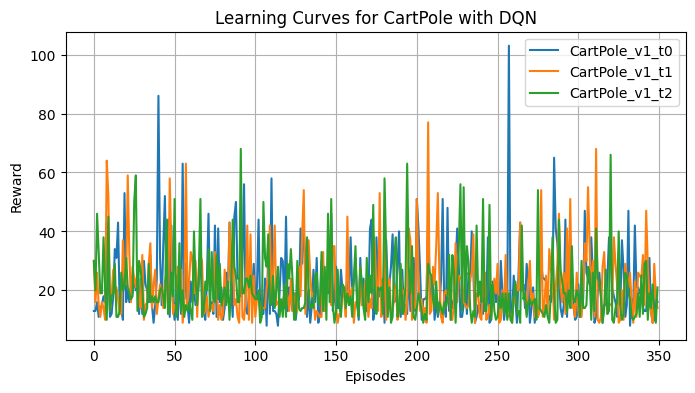

In [ ]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

# Define the list of experiment names
exp_names = ['CartPole_v1_t0', 'CartPole_v1_t1', 'CartPole_v1_t2']

# Load the data for each experiment
all_rewards = []
for exp_name in exp_names:
    file_name = exp_name + '.pkl'
    with open(file_name, 'rb') as f:
        rewards = pickle.load(f)
    all_rewards.append(rewards)

# Plot the data
plt.figure(figsize=(8, 4))
for i in range(len(exp_names)):
    sns.lineplot(data=all_rewards[i], label=exp_names[i])
plt.xlabel('Episodes', fontsize=10)
plt.ylabel('Reward', fontsize=10)
plt.title('Learning Curves for CartPole with DQN', fontsize=12)
plt.legend()
plt.grid()
plt.show()
#highest maximum reward is (cartpole-v1-t1)

In [ ]:
params_list= [
 {
    'env_name': 'CartPole-v1',
    'rng_seed': 6369,
    'n_episode': 350,
    'rm_cap': 8192,
    'batch_size': 128,
    'hidden_dim': 128,
    'init_epsilon': 0.0,
    'min_epsilon': 0.00,
    'epsilon_decay': 0.99,
    'gamma': 0.99,
    'tau': 0.05,
    'lr': 3e-3,
    'exp_name': 'CartPole_v1_t3'
},

{
    'env_name': 'CartPole-v1',
    'rng_seed': 6369,
    'n_episode': 350,
    'rm_cap': 8192,
    'batch_size': 128,
    'hidden_dim': 128,
    'init_epsilon': 0.1,
    'min_epsilon': 0.05,
    'epsilon_decay': 0.99,
    'gamma': 0.99,
    'tau': 0.05,
    'lr': 3e-3,
    'exp_name': 'CartPole_v1_t4'
}
]


# Train agent with each set of parameters
for params in params_list:
    # Seed RNGs
    seed_everything(params['rng_seed'])
# Train agent
    trainer = DQNTrainer(params)
    trainer.run_training_loop()

End of episode 0 with epsilon =  0.00 and reward = 10, memory = 10
End of episode 1 with epsilon =  0.00 and reward = 9, memory = 19
End of episode 2 with epsilon =  0.00 and reward = 10, memory = 29
End of episode 3 with epsilon =  0.00 and reward = 8, memory = 37
End of episode 4 with epsilon =  0.00 and reward = 8, memory = 45
End of episode 5 with epsilon =  0.00 and reward = 8, memory = 53
End of episode 6 with epsilon =  0.00 and reward = 9, memory = 62
End of episode 7 with epsilon =  0.00 and reward = 10, memory = 72
End of episode 8 with epsilon =  0.00 and reward = 8, memory = 80
End of episode 9 with epsilon =  0.00 and reward = 8, memory = 88
End of episode 10 with epsilon =  0.00 and reward = 10, memory = 98
End of episode 11 with epsilon =  0.00 and reward = 10, memory = 108
End of episode 12 with epsilon =  0.00 and reward = 8, memory = 116
End of episode 13 with epsilon =  0.00 and reward = 10, memory = 126
End of episode 14 with epsilon =  0.00 and reward = 9, memory =

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


End of episode 15 with epsilon =  0.00 and reward = 10, memory = 145
End of episode 16 with epsilon =  0.00 and reward = 10, memory = 155
End of episode 17 with epsilon =  0.00 and reward = 10, memory = 165
End of episode 18 with epsilon =  0.00 and reward = 10, memory = 175
End of episode 19 with epsilon =  0.00 and reward = 8, memory = 183
End of episode 20 with epsilon =  0.00 and reward = 9, memory = 192
End of episode 21 with epsilon =  0.00 and reward = 9, memory = 201
End of episode 22 with epsilon =  0.00 and reward = 8, memory = 209
End of episode 23 with epsilon =  0.00 and reward = 10, memory = 219
End of episode 24 with epsilon =  0.00 and reward = 10, memory = 229
End of episode 25 with epsilon =  0.00 and reward = 10, memory = 239
End of episode 26 with epsilon =  0.00 and reward = 9, memory = 248
End of episode 27 with epsilon =  0.00 and reward = 10, memory = 258
End of episode 28 with epsilon =  0.00 and reward = 10, memory = 268
End of episode 29 with epsilon =  0.00 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Assgnmt2_DQN/CartPole/rl-video-episode-0.mp4
End of episode 0 with epsilon =  0.10 and reward = 10, memory = 10
End of episode 1 with epsilon =  0.10 and reward = 9, memory = 19
End of episode 2 with epsilon =  0.10 and reward = 10, memory = 29
End of episode 3 with epsilon =  0.10 and reward = 8, memory = 37
End of episode 4 with epsilon =  0.10 and reward = 8, memory = 45
End of episode 5 with epsilon =  0.09 and reward = 8, memory = 53
End of episode 6 with epsilon =  0.09 and reward = 9, memory = 62
End of episode 7 with epsilon =  0.09 and reward = 12, memory = 74
End of episode 8 with epsilon =  0.09 and reward = 8, memory = 82
End of episode 9 with epsilon =  0.09 and reward = 8, memory = 90
End of episode 10 with epsilon =  0.09 and reward = 10, memory = 100
End of episode 11 with epsilon =  0.09 and reward = 10, memory = 110
End of episode 12 with epsilon =  0.09 and reward = 10, memory = 120


End of episode 13 with epsilon =  0.09 and reward = 10, memory = 130
End of episode 14 with epsilon =  0.09 and reward = 9, memory = 139
End of episode 15 with epsilon =  0.09 and reward = 17, memory = 156
End of episode 16 with epsilon =  0.08 and reward = 16, memory = 172
End of episode 17 with epsilon =  0.08 and reward = 17, memory = 189
End of episode 18 with epsilon =  0.08 and reward = 14, memory = 203
End of episode 19 with epsilon =  0.08 and reward = 8, memory = 211
End of episode 20 with epsilon =  0.08 and reward = 10, memory = 221
End of episode 21 with epsilon =  0.08 and reward = 12, memory = 233
End of episode 22 with epsilon =  0.08 and reward = 11, memory = 244
End of episode 23 with epsilon =  0.08 and reward = 14, memory = 258
End of episode 24 with epsilon =  0.08 and reward = 15, memory = 273
End of episode 25 with epsilon =  0.08 and reward = 11, memory = 284
End of episode 26 with epsilon =  0.08 and reward = 12, memory = 296
End of episode 27 with epsilon =  0.

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Assgnmt2_DQN/CartPole/rl-video-episode-0.mp4


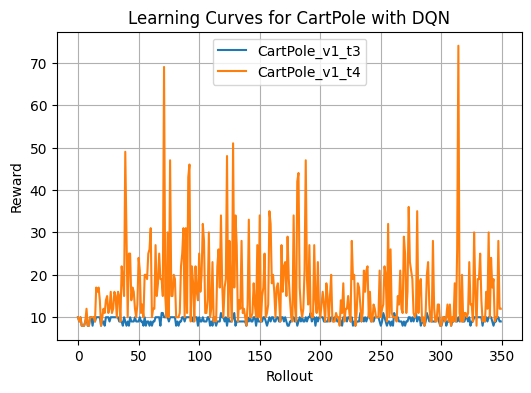

In [ ]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

# Define the list of experiment names
exp_names = ['CartPole_v1_t3', 'CartPole_v1_t4']

# Load the data for each experiment
all_rewards = []
for exp_name in exp_names:
    file_name = exp_name + '.pkl'
    with open(file_name, 'rb') as f:
        rewards = pickle.load(f)
    all_rewards.append(rewards)

# Plot the data
plt.figure(figsize=(6, 4))
for i in range(len(exp_names)):
    sns.lineplot(data=all_rewards[i], label=exp_names[i])
plt.xlabel('Rollout', fontsize=10)
plt.ylabel('Reward', fontsize=10)
plt.title('Learning Curves for CartPole with DQN', fontsize=12)
plt.legend()
plt.grid()
plt.show()
#highest maximum reward is (cartpole-v1-t2)

# STUDENT NAME: Naveyah Injam
# STUDENT ID: 1002029985
